## Random Forest Classifier:

Using a combination of governance characteristics and organizational characteristics (revenue, assets, ect.) I will predict salary using a Random Forest Classifier model.

In [181]:
import numpy as np
from numpy import random
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from numpy import interp
import joblib

## IMPORT DATA

In [133]:
# import modeling dataset
features = pd.get_dummies(pd.read_csv('02.data/model_dataset_features_eng.csv'))
X = features.drop(['reportable_comp'], axis=1)

y = pd.read_csv('02.data/target_categories_box_cox.csv', header=None, squeeze=True)

In [134]:
# verify the size of target and
# feature datasets are the same
X.shape[0] == y.shape[0]

True

## RANDOM FOREST CLASSIFIER
<a id='random_forest'></a>

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [5]:
# randomly choose 10K rows
# to parameter tune on
feature_sample = pd.concat([
    X_train,
    y_train
], axis=1).sample(n=10000)

X_train_sample = feature_sample.drop(0, axis=1)
y_train_sample = feature_sample.loc[:, 0]

In [7]:
# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'log2'],
#     'max_depth' : [4,10,20,50],
#     'criterion' : ['gini', 'entropy'],
#     'warm_start': [True]
# }

# cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3)
# cv_rfc.fit(X_train_sample, y_train_sample)

In [320]:
cv_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 500,
 'warm_start': True}

In [37]:
# save best parameters
joblib.dump({'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 500,
 'warm_start': True}, '08.models/rfc_params.pkl')

['08.models/rfc_params.pkl']

In [136]:
# set model to best params
rfc = ensemble.RandomForestClassifier(**joblib.load('08.models/rfc_params.pkl'))

In [137]:
# fit model
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=True)

In [140]:
# save model
joblib.dump(rfc, '08.models/rfc_model.pkl')

['08.models/rfc_model.pkl']

In [120]:
# load model from pickel
rfc = joblib.load('08.models/rfc_model.pkl')

In [149]:
# all cross val scores are 
# lower than test score
cross_val_score(rfc, X_train, y_train, cv=5)

array([0.25737543, 0.26173313, 0.25303392, 0.25364386, 0.25640627])

In [152]:
rfc.score(X_train, y_train)

0.35207293924841043

In [151]:
# test model on unseen data
rfc.score(X_test, y_test)

0.2595527527693648

In [141]:
# predict categores
pred = rfc.predict(X_test)

In [142]:
# create confusion matrix and
# normalize the matrix to more accurately 
# compare which predictions the model is getting wrong
norm_conf_matrix = confusion_matrix(y_test, pred) / \
confusion_matrix(y_test, pred).sum(axis=1, keepdims=True)

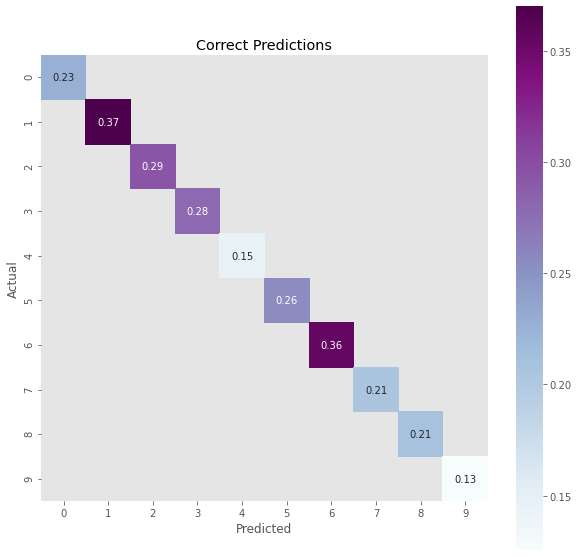

In [143]:
# display only the diagonal values
# representing values the model correctly predicted
plt.figure(figsize=(10, 10))

sns.heatmap(np.where(np.diagflat(np.diagonal(norm_conf_matrix))
            ==0, np.nan, np.diagflat(np.diagonal(norm_conf_matrix))),
            cmap='BuPu',
            annot=True,
            square=True,
            );
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Correct Predictions');

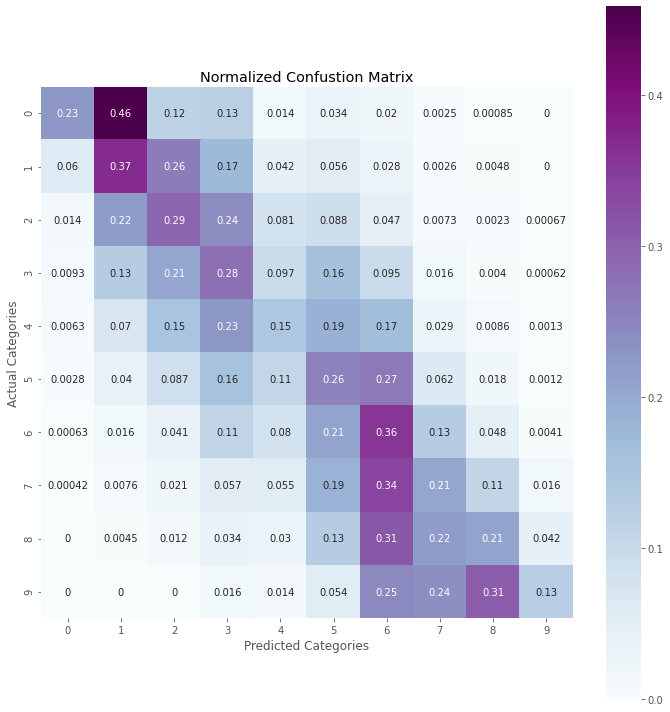

In [179]:
# compare correct and incorrect predictions
plt.figure(figsize=(10, 10))
# np.fill_diagonal(norm_conf_matrix, 0)

ax = sns.heatmap(norm_conf_matrix, 
                 square=True, annot=True, 
                 cmap='BuPu')

plt.ylabel('Actual Categories')
plt.xlabel('Predicted Categories')
plt.title('Normalized Confustion Matrix')
plt.tight_layout()
plt.savefig('03.visualizations/heat_map_rfc.png');

In [184]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      0.529     0.227     0.318      1181
           1      0.292     0.370     0.327      2282
           2      0.273     0.294     0.284      2999
           3      0.228     0.280     0.251      3212
           4      0.232     0.145     0.179      3040
           5      0.220     0.255     0.236      3210
           6      0.245     0.356     0.290      3169
           7      0.260     0.206     0.230      2361
           8      0.320     0.211     0.254      1781
           9      0.443     0.126     0.196       868

    accuracy                          0.260     24103
   macro avg      0.304     0.247     0.256     24103
weighted avg      0.274     0.260     0.256     24103



In [145]:
f_importances = pd.Series(rfc.feature_importances_, 
          X_train.columns).sort_values(ascending=False)

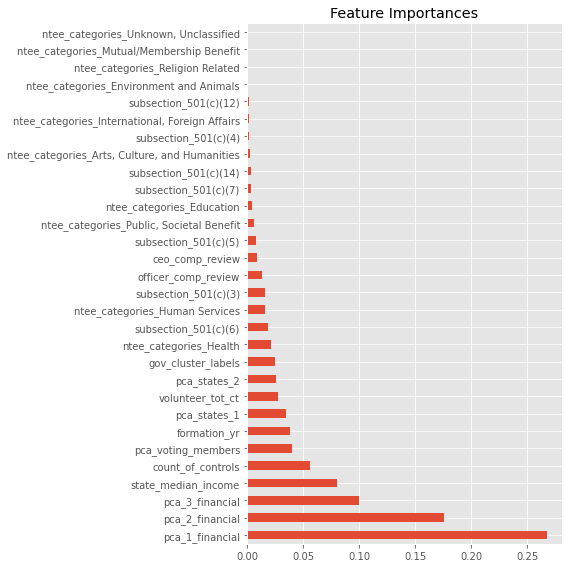

In [155]:
f_importances.plot(kind='barh', figsize=(8, 8))

plt.title('Feature Importances')

plt.tight_layout()
plt.savefig('03.visualizations/rfc_feature_importance.png');

### Examine distributions for each cluster based on my cluster prediction 

In [42]:
# join predictions with actual salaries
pred_with_salary = pd.concat([features.iloc[X_test.index].reportable_comp.reset_index(drop=True),
           pd.Series(pred)], axis=1)

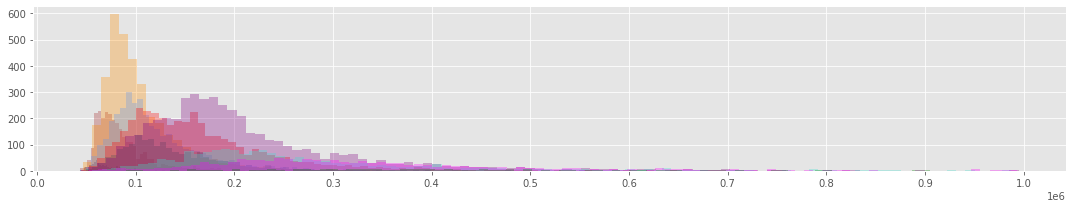

In [167]:
colors = ['navy', 
        'brown', 
        'darkorange', 
        'cornflowerblue', 
        'teal',
        'red',
       'purple',
       'turquoise',
       'magenta',
       'green']

plt.figure(figsize=(15, 3))

for i, color in enumerate(colors):
    pred_with_salary[pred_with_salary[0] == i].iloc[:,0].hist(bins=100, alpha=.3, color=color)

plt.xticks([x for x in range(0, 1100000, 100000)])
plt.tight_layout()
plt.savefig('03.visualizations/classification_hist.png');

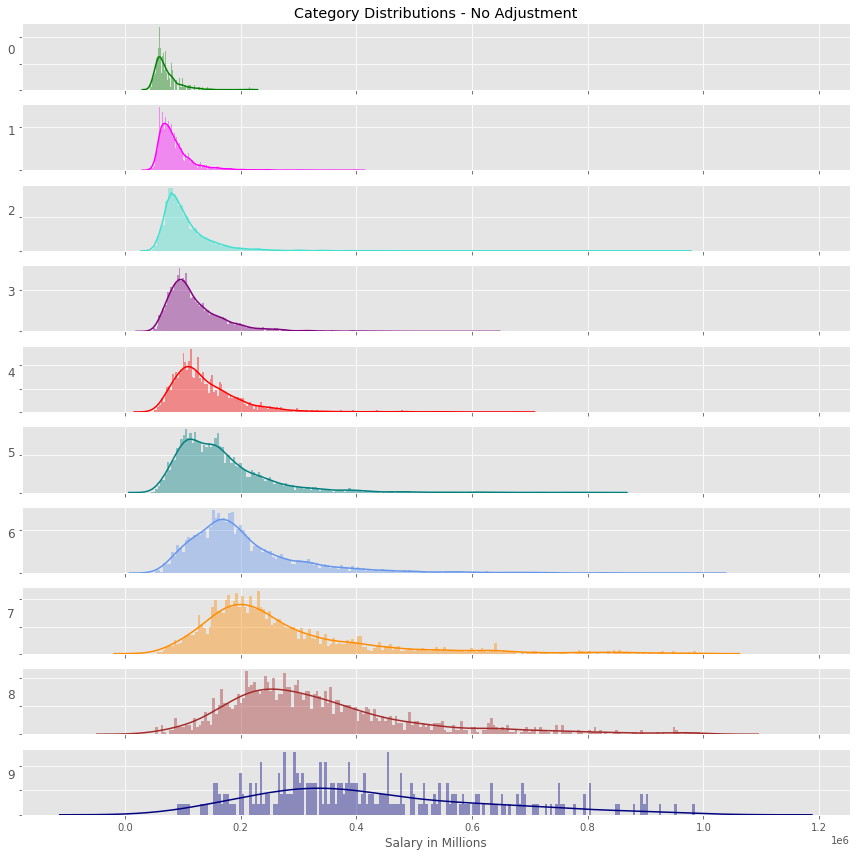

In [162]:
# plot category distributions in separate plots
# with kernel density for each category

colors = ['navy', 
        'brown', 
        'darkorange', 
        'cornflowerblue', 
        'teal',
        'red',
       'purple',
       'turquoise',
       'magenta',
       'green']

# reverse color order to correspond with 
# ordering in other areas of my presentation
colors.reverse()

fig, ax = plt.subplots(nrows=10, ncols=1, sharex=True, figsize=(12, 12))

for i, color in enumerate(colors):
    sns.distplot(pred_with_salary[pred_with_salary[0] == i].iloc[:,0],
                 bins=200,
                 color=color, ax=ax[i])
    ax[i].set_yticklabels('')
    ax[i].set_ylabel(i, rotation=0)
    ax[i].set_xlabel('')
    
ax[0].set_title('Category Distributions - No Adjustment')
ax[9].set_xlabel('Salary in Millions')

plt.tight_layout()
# plt.savefig('03.visualizations/classification_hist_kde.png');

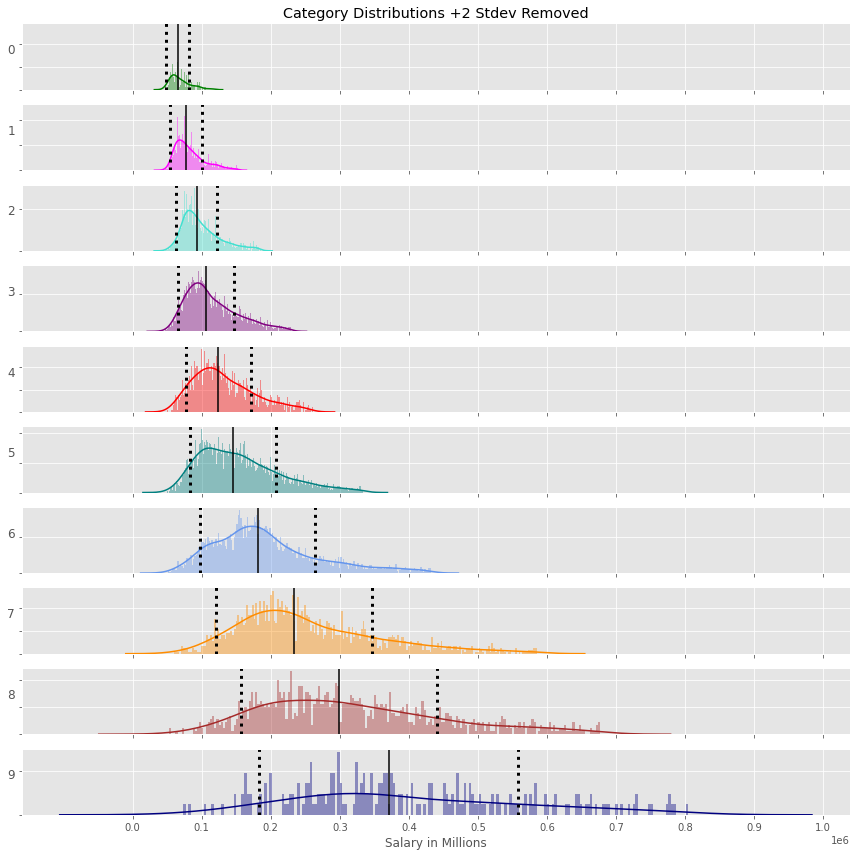

In [75]:
# plot category distributions in separate plots
# with kernel density for each category
# with median and stdeve lines

colors = ['navy', 
        'brown', 
        'darkorange', 
        'cornflowerblue', 
        'teal',
        'red',
       'purple',
       'turquoise',
       'magenta',
       'green']

# reverse color order to correspond with 
# ordering in other areas of my presentation
colors.reverse()

fig, ax = plt.subplots(nrows=10, ncols=1, sharex=True, figsize=(12, 12))

for i, color in enumerate(colors):
    sns.distplot(pred_with_salary[pred_with_salary[0] == i].iloc[:,0] \
                 [stats.zscore(pred_with_salary[pred_with_salary[0] == i].iloc[:,0]) < 2],
                 bins=200,
                 color=color, ax=ax[i])
    ax[i].set_yticklabels('')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(i, rotation=0)

# print median line for each category
    ax[i].axvline(pred_with_salary[pred_with_salary[0] == i].iloc[:,0] \
                 [stats.zscore(pred_with_salary[pred_with_salary[0] == i].iloc[:,0]) < 2.5].median(), 
                  color='black')
    
# print standard deviation lines for each category
    ax[i].axvline(pred_with_salary[pred_with_salary[0] == i].iloc[:,0] \
             [stats.zscore(pred_with_salary[pred_with_salary[0] == i].iloc[:,0]) < 2.5].std() + \
    pred_with_salary[pred_with_salary[0] == i].iloc[:,0] \
                 [stats.zscore(pred_with_salary[pred_with_salary[0] == i].iloc[:,0]) < 2.5].median(), 
              color='black', linestyle=':', lw=3)
    
    ax[i].axvline(pred_with_salary[pred_with_salary[0] == i].iloc[:,0] \
            [stats.zscore(pred_with_salary[pred_with_salary[0] == i].iloc[:,0]) < 2.5].median() - \
                  pred_with_salary[pred_with_salary[0] == i].iloc[:,0] \
            [stats.zscore(pred_with_salary[pred_with_salary[0] == i].iloc[:,0]) < 2.5].std(), 
              color='black', linestyle=':', lw=3)
    
ax[0].set_title('Category Distributions +2 Stdev Removed')
ax[9].set_xlabel('Salary in Millions')

plt.xticks([x for x in range(0, 1100000, 100000)])
# plt.ticklabel_format(style='plain')

plt.tight_layout()
plt.savefig('03.visualizations/classification_hist_kde_median_marker.png');

### Examine the normality of the category distributions

In [44]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
# This function tests the null hypothesis that a sample comes from a normal distribution. 

for i in range(0, 10):
    t, p = stats.normaltest(pred_with_salary[pred_with_salary[0] == i].iloc[:,0])
    print('{}. - {}.'.format(t,p))

246.21924241725316. - 3.4211399459023884e-54.
1810.9576772849036. - 0.0.
3283.401555812009. - 0.0.
1919.948476638819. - 0.0.
1050.3487097942855. - 8.311427694423092e-229.
2015.3867742502016. - 0.0.
2212.285845841143. - 0.0.
649.7486509052072. - 8.107242131698688e-142.
307.72873254810537. - 1.5050632991441627e-67.
18.388455789216614. - 0.00010162429833138958.


None of these p-values are anywhere close to the .05 threshold, meaning we must reject the null hypothesis that the distribution of salary classifications for each category are normally distributed.

### Confidence Interval
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bayes_mvs.html

In [54]:
# Mean
for i in range(0, 10):
    print(i, stats.bayes_mvs(pred_with_salary[pred_with_salary[0] == i].iloc[:,0], .80)[0])

0 Mean(statistic=70316.93413173653, minmax=(69215.6851632173, 71418.18310025576))
1 Mean(statistic=87812.9017094017, minmax=(86988.27233894137, 88637.53107986203))
2 Mean(statistic=105583.08075063975, minmax=(104612.42813804632, 106553.73336323319))
3 Mean(statistic=122622.95755375593, minmax=(121482.70328718238, 123763.21182032948))
4 Mean(statistic=140350.86103687866, minmax=(138513.91032395596, 142187.81174980136))
5 Mean(statistic=167047.26683937825, minmax=(165318.14562362278, 168776.38805513372))
6 Mean(statistic=209795.82728249195, minmax=(207718.82284979426, 211872.83171518965))
7 Mean(statistic=270858.0501730104, minmax=(266219.1852894441, 275496.91505657666))
8 Mean(statistic=337240.5523520486, minmax=(331378.937026798, 343102.1676772991))
9 Mean(statistic=425701.9534883721, minmax=(409990.3271769124, 441413.5797998318))


In [55]:
# Std
for i in range(0, 10):
    print(i, stats.bayes_mvs(pred_with_salary[pred_with_salary[0] == i].iloc[:,0], .95)[2])

0 Std_dev(statistic=22546.64364229021, minmax=(21220.129202699303, 23976.84281151314))
1 Std_dev(statistic=32787.5050023286, minmax=(31946.305863773887, 33628.70414088332))
2 Std_dev(statistic=40784.212616653174, minmax=(39790.59125687547, 41777.83397643088))
3 Std_dev(statistic=53559.175360837224, minmax=(52374.21867560568, 54744.132046068764))
4 Std_dev(statistic=61322.670687873666, minmax=(59321.7222970133, 63323.61907873403))
5 Std_dev(statistic=83657.98512316057, minmax=(81851.01879326408, 85464.95145305706))
6 Std_dev(statistic=111220.35070161981, minmax=(108876.25946798077, 113564.44193525886))
7 Std_dev(statistic=152283.47951625285, minmax=(147308.9772613812, 157257.9817711245))
8 Std_dev(statistic=168115.2998646698, minmax=(161455.67718167618, 174774.92254766342))
9 Std_dev(statistic=192848.09373155475, minmax=(176411.79505915847, 211211.9109740197))


## Pred_probab distributions as confidence intervals

C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\mr

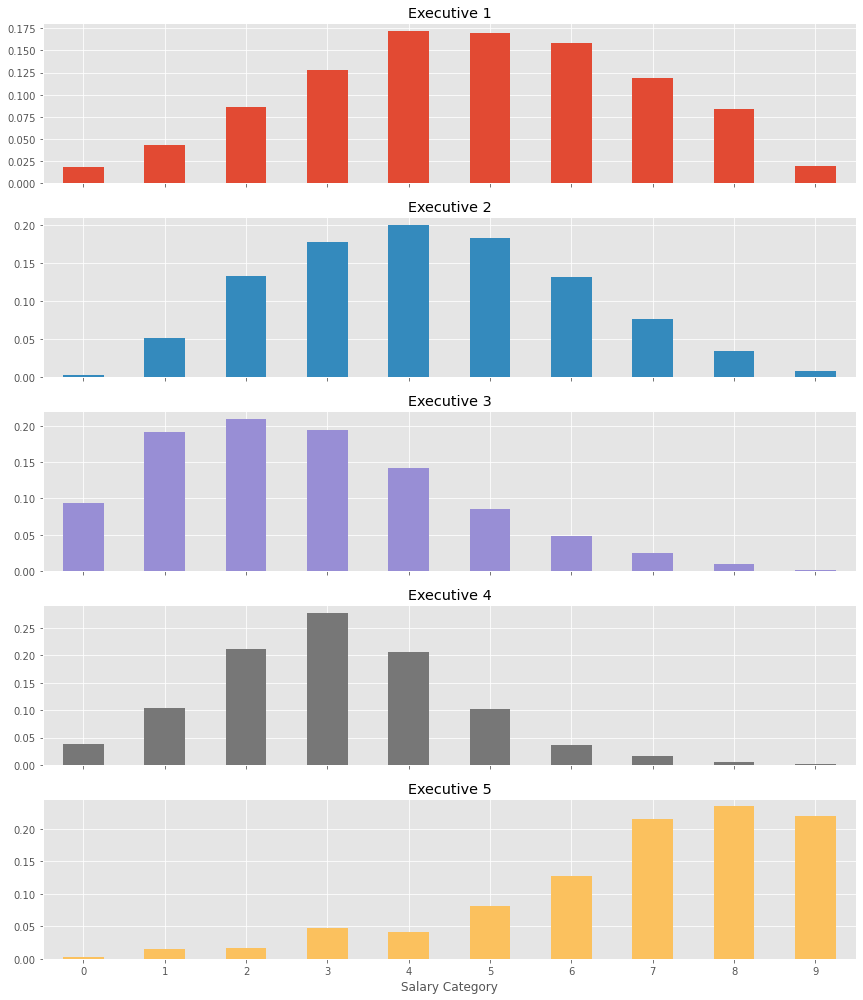

In [101]:
ax = prob_pred.iloc[6:11,:].T.rename({6: 'Executive 1',
                               7: 'Executive 2',
                               8: 'Executive 3',
                               9: 'Executive 4',
                               10: 'Executive 5'}, axis=1).plot(kind='bar', 
                             subplots=True, 
                             figsize=(12,14), 
                             sharex=True,
                            legend=False)

plt.xticks(rotation=0)
plt.xlabel('Salary Category')
plt.tight_layout()
plt.savefig('03.visualizations/pred_probaba_dist.png');

## Examining MSE difference between predicted salary and classification salary 

### 1. Compare category assignment salaries against actual salaries and compute MSE(mean squared error)

In [337]:
# access median salary for each category within dictionary
pd.Series(pred).apply(lambda x: category_median_salary[x])

0        101667.5
1         85079.0
2        152129.0
3        241712.0
4        241712.0
           ...   
60251    152129.0
60252    152129.0
60253     85079.0
60254    537557.5
60255    152129.0
Length: 60256, dtype: float64

In [338]:
np.sqrt(mean_squared_error(y_test, pd.Series(pred).apply(lambda x: category_median_salary[x])))

180101.6969774165

### 2. Compare composite salaries against actual salaries and compute MSE(mean squared error)

In [76]:
# examine probability of assignment
# to specific categories
prob_pred = pd.DataFrame(rfc.predict_proba(X_test))

In [349]:
prob_pred

,0,1,2,3,4,5,6,7,8,9
0,0.113934,0.180987,0.195080,0.187980,0.128736,0.094749,0.054898,0.029505,0.011476,0.002655
1,0.184599,0.295921,0.215759,0.141973,0.078078,0.043825,0.024378,0.011022,0.003728,0.000716
2,0.001819,0.020141,0.026286,0.056999,0.079964,0.149815,0.212494,0.196717,0.171020,0.084745
3,0.055120,0.088273,0.136807,0.151623,0.169539,0.157274,0.116859,0.073354,0.038900,0.012249
4,0.272923,0.318548,0.193260,0.119485,0.051679,0.024772,0.012828,0.004165,0.002209,0.000129
...,...,...,...,...,...,...,...,...,...,...
24098,0.155373,0.230349,0.224096,0.167549,0.110130,0.061559,0.029989,0.013186,0.006708,0.001062
24099,0.002819,0.059351,0.124576,0.168127,0.157755,0.165808,0.140576,0.096513,0.064909,0.019567
24100,0.023897,0.047121,0.066365,0.087673,0.162561,0.212789,0.148353,0.124841,0.083919,0.042481
24101,0.002280,0.005518,0.011384,0.027566,0.031888,0.081223,0.145086,0.210797,0.296320,0.187939


In [350]:
# import dict with mean salary for each category
category_median_salary = pd.read_csv('02.data/category_median_salary.csv', squeeze=True).to_dict()

In [351]:
# examine dictionary to make sure it looks as it should
category_median_salary

{0: 60000.0,
 1: 72000.0,
 2: 85079.0,
 3: 101667.5,
 4: 122761.0,
 5: 152129.0,
 6: 187775.0,
 7: 241712.0,
 8: 333669.0,
 9: 537557.5}

In [352]:
# multipy each column probability by 
# the median value for that salary category
frac_salary = pd.DataFrame(prob_pred)

for column in frac_salary.columns:
    frac_salary[column] = frac_salary[column] * category_mean_salary[column]

In [353]:
frac_salary

,0,1,2,3,4,5,6,7,8,9
0,6836.066156,13031.076912,16597.214786,19111.433624,15803.755407,14414.025619,10308.492345,7131.803353,3829.136075,1426.983047
1,11075.914965,21306.319895,18356.576910,14434.083523,9584.906161,6667.055264,4577.541838,2664.263899,1244.076524,384.966197
2,109.156156,1450.127657,2236.428809,5794.955283,9816.494469,22791.214908,39900.982199,47548.753713,57064.145719,45555.193631
3,3307.208701,6355.647248,11639.415432,15415.158001,20812.829748,23925.970929,21943.190429,17730.572754,12979.849605,6584.784182
4,16375.366821,22935.464011,16442.407179,12147.791875,6344.201393,3768.508242,2408.850974,1006.850933,737.166039,69.290052
...,...,...,...,...,...,...,...,...,...,...
24098,9322.356889,16585.096843,19065.836590,17034.257060,13519.681447,9364.941400,5631.259869,3187.120147,2238.131591,571.140475
24099,169.136350,4273.304287,10598.797504,17093.001465,19366.118014,25224.158933,26396.636270,23328.233532,21658.272721,10518.365930
24100,1433.797390,3392.734788,5646.274653,8913.483545,19956.105709,32371.438709,27857.069307,30175.490648,28001.204626,22835.882616
24101,136.789770,397.271029,968.541842,2802.563508,3914.554856,12356.409599,27243.513850,50952.086555,98872.840092,101027.975307


In [354]:
np.sqrt(mean_squared_error(y_test, frac_salary.sum(axis=1)))

172653.36594441545

### 3. Compare category assignment for top two categories against actual salaries and compute MSE(mean squared error)

In [355]:
# find top two percents
top_two_prob = pd.DataFrame(prob_pred).apply(lambda x: pd.Series(x.nlargest(2)), axis=1)

In [356]:
# prorate percentages to 100% total
top_two_prob = top_two_prob.div(top_two_prob.sum(axis=1), axis=0)

In [357]:
# multiply each percent by 
# corresponding median category level
for column in top_two_prob.columns:
    top_two_prob[column] = top_two_prob[column] * category_median_salary[column]

In [358]:
np.sqrt(mean_squared_error(y_test, top_two_prob.sum(axis=1)))

220752.28615095565

### Comparison between all methods

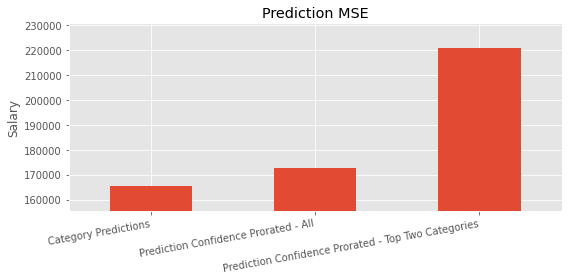

In [425]:
# combine adjustments to be able to plot
# and visualize differences between each
ax = pd.DataFrame(index=['Category Predictions',
    'Prediction Confidence Prorated - All',
    'Prediction Confidence Prorated - Top Two Categories'],
data=[np.sqrt(mean_squared_error(y_test, pd.Series(pred).apply(lambda x: category_median_salary[x]))),
np.sqrt(mean_squared_error(y_test, frac_salary.sum(axis=1))),
np.sqrt(mean_squared_error(y_test, top_two_prob.sum(axis=1)))]).plot(kind='bar',
                                                                      figsize=(8,4), 
                                                                    legend=False)

plt.ylim((pd.DataFrame(index=['Category Predictions',
    'Prediction Confidence Prorated - All',
    'Prediction Confidence Prorated - Top Two Categories'],
data=[np.sqrt(mean_squared_error(y_test, pd.Series(pred).apply(lambda x: category_median_salary[x]))),
np.sqrt(mean_squared_error(y_test, frac_salary.sum(axis=1))),
np.sqrt(mean_squared_error(y_test, top_two_prob.sum(axis=1)))]).min() - 10000).values,
         (pd.DataFrame(index=['Category Predictions',
    'Prediction Confidence Prorated - All',
    'Prediction Confidence Prorated - Top Two Categories'],
data=[np.sqrt(mean_squared_error(y_test, pd.Series(pred).apply(lambda x: category_median_salary[x]))),
np.sqrt(mean_squared_error(y_test, frac_salary.sum(axis=1))),
np.sqrt(mean_squared_error(y_test, top_two_prob.sum(axis=1)))]).max() + 10000).values)

plt.title('Prediction MSE')
plt.ylabel('Salary')
plt.xticks(rotation=10, horizontalalignment="right")

plt.tight_layout()
plt.savefig('03.visualizations/classification_adjust.png');